In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
import optuna
import multiprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from tqdm import tqdm

In [18]:
train_metadata = pd.read_csv('../datasets/wbc/clean/train_metadata.csv')
test_metadata  = pd.read_csv('../datasets/wbc/clean/test_metadata.csv' )

# GGB + K-Means

In [19]:
label_names = sorted(train_metadata['label'].unique())
X_train, X_test = [], []
for label in tqdm(label_names):
    X_train.append(np.load('../datasets/wbc/clean/hog_features_segm_train_{}.npz'.format(label))['arr_0'])
    X_test.append(np.load('../datasets/wbc/clean/hog_features_segm_test_{}.npz'.format(label))['arr_0'])

X_train = np.concatenate(X_train)
X_test  = np.concatenate(X_test)

le = LabelEncoder()
le.fit(train_metadata['label'])
y_train = le.transform(train_metadata['label'])
y_test  = le.transform(test_metadata['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


In [22]:
n_jobs = multiprocessing.cpu_count() // 2
print('Num jobs:', n_jobs)

model = xgb.XGBClassifier(
    n_estimators=20,
    random_state=0,
    n_jobs=n_jobs,
    early_stopping_rounds=5
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

Num jobs: 4
[0]	validation_0-mlogloss:1.18102
[1]	validation_0-mlogloss:0.96875
[2]	validation_0-mlogloss:0.83034
[3]	validation_0-mlogloss:0.73339
[4]	validation_0-mlogloss:0.66668
[5]	validation_0-mlogloss:0.61363
[6]	validation_0-mlogloss:0.57781
[7]	validation_0-mlogloss:0.55123
[8]	validation_0-mlogloss:0.53051
[9]	validation_0-mlogloss:0.51324
[10]	validation_0-mlogloss:0.50108
[11]	validation_0-mlogloss:0.49077
[12]	validation_0-mlogloss:0.48231
[13]	validation_0-mlogloss:0.47429
[14]	validation_0-mlogloss:0.46766
[15]	validation_0-mlogloss:0.46083
[16]	validation_0-mlogloss:0.45893
[17]	validation_0-mlogloss:0.45670
[18]	validation_0-mlogloss:0.45357
[19]	validation_0-mlogloss:0.45303


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

## Metrics

In [24]:
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

train_score  = f1_score(y_train, y_pred_train, average='micro')
val_score    = f1_score(y_val, y_pred_val, average='micro')
test_score   = f1_score(y_test, y_pred_test, average='micro')

print('Training metrics:')
print(classification_report(y_train, y_pred_train, digits=4))
print('Validation metrics:')
print(classification_report(y_val, y_pred_val, digits=4))
print('Testing metrics:')
print(classification_report(y_test, y_pred_test, digits=4))

Training metrics:
              precision    recall  f1-score   support

           0     1.0000    0.9727    0.9861       183
           1     1.0000    0.9684    0.9840       665
           2     0.9991    0.9940    0.9965      2168
           3     1.0000    0.9415    0.9699       496
           4     0.9884    1.0000    0.9942      5645

    accuracy                         0.9926      9157
   macro avg     0.9975    0.9753    0.9861      9157
weighted avg     0.9927    0.9926    0.9925      9157

Validation metrics:
              precision    recall  f1-score   support

           0     1.0000    0.3448    0.5128        29
           1     0.7097    0.2785    0.4000        79
           2     0.8873    0.9421    0.9139       259
           3     0.5909    0.2000    0.2989        65
           4     0.8382    0.9727    0.9005       586

    accuracy                         0.8438      1018
   macro avg     0.8052    0.5476    0.6052      1018
weighted avg     0.8296    0.8438    0.

## Conf Matrix

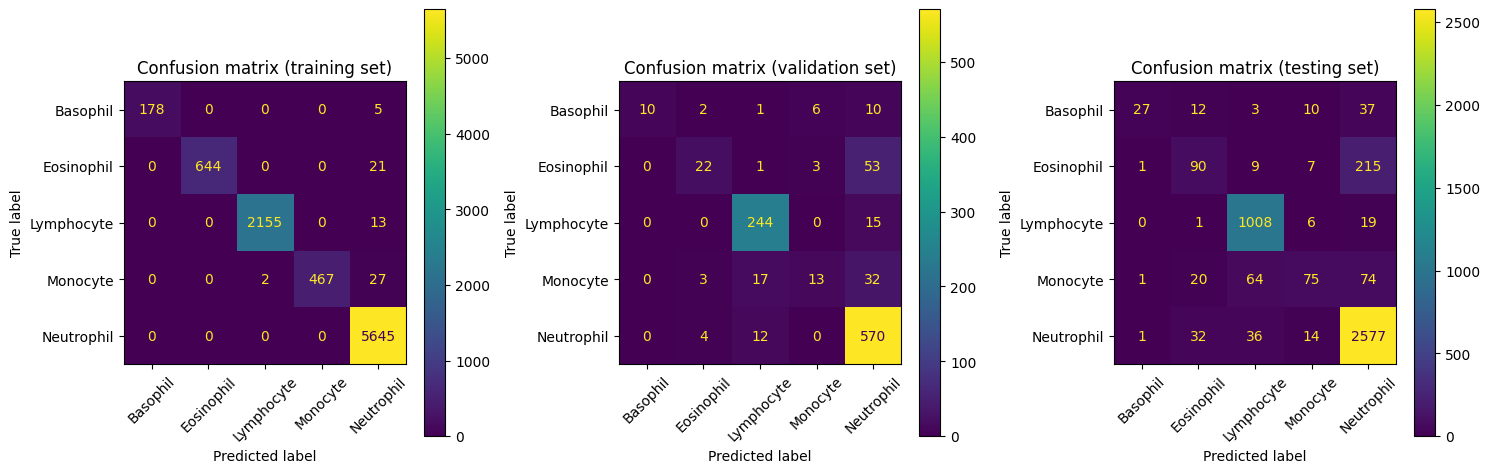

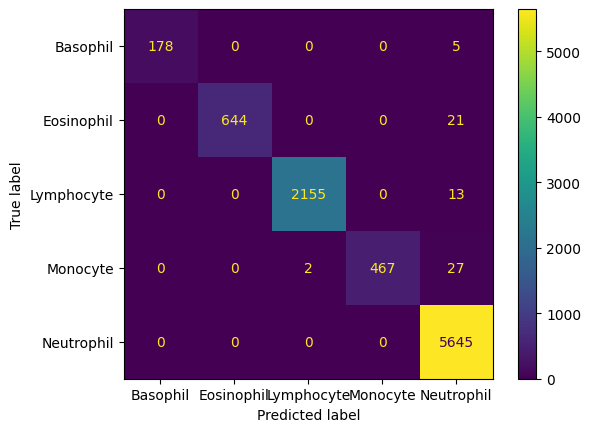

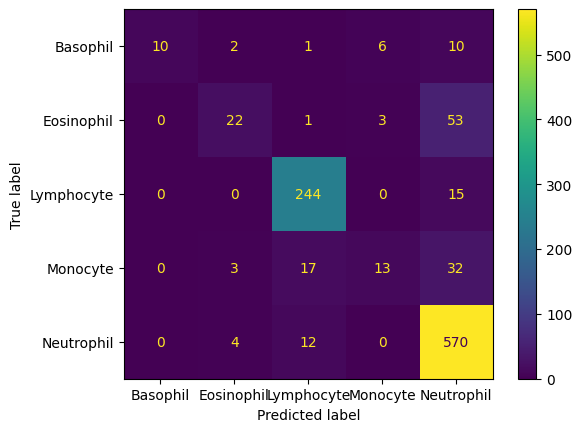

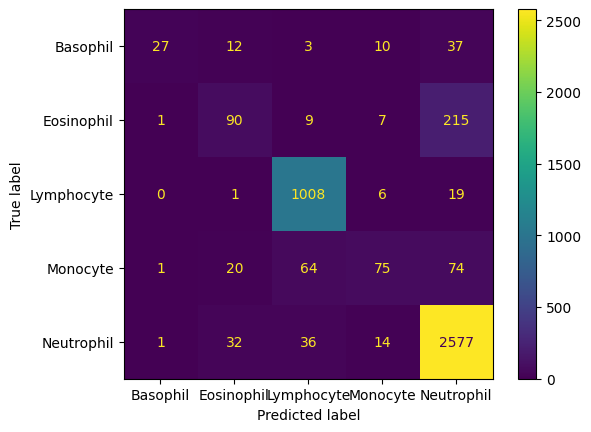

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# print('Confusion matrix (training set):')
cm = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=label_names  )
cm.plot(ax=ax[0])
ax[0].set_title('Confusion matrix (training set)')

# print('Confusion matrix (validation set):')
cm = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=label_names)
cm.plot(ax=ax[1])
ax[1].set_title('Confusion matrix (validation set)')

# print('Confusion matrix (testing set):')
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=label_names)
cm.plot(ax=ax[2])
ax[2].set_title('Confusion matrix (testing set)')

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

fig.tight_layout()
plt.show()

# GGB

In [26]:
label_names = sorted(train_metadata['label'].unique())
X_train, X_test = [], []
for label in tqdm(label_names):
    X_train.append(np.load('../datasets/wbc/clean/hog_features_ggb_train_{}.npz'.format(label))['arr_0'])
    X_test.append(np.load('../datasets/wbc/clean/hog_features_ggb_test_{}.npz'.format(label))['arr_0'])

X_train = np.concatenate(X_train)
X_test  = np.concatenate(X_test)

le = LabelEncoder()
le.fit(train_metadata['label'])
y_train = le.transform(train_metadata['label'])
y_test  = le.transform(test_metadata['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


In [28]:
n_jobs = multiprocessing.cpu_count() // 2
print('Num jobs:', n_jobs)

model = xgb.XGBClassifier(
    n_estimators=20,
    random_state=0,
    n_jobs=n_jobs,
    early_stopping_rounds=5
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

Num jobs: 4
[0]	validation_0-mlogloss:1.18127
[1]	validation_0-mlogloss:0.96790
[2]	validation_0-mlogloss:0.82595
[3]	validation_0-mlogloss:0.72871
[4]	validation_0-mlogloss:0.65966
[5]	validation_0-mlogloss:0.60917
[6]	validation_0-mlogloss:0.56745
[7]	validation_0-mlogloss:0.53633
[8]	validation_0-mlogloss:0.51070
[9]	validation_0-mlogloss:0.48826
[10]	validation_0-mlogloss:0.46964
[11]	validation_0-mlogloss:0.45527
[12]	validation_0-mlogloss:0.44342
[13]	validation_0-mlogloss:0.43244
[14]	validation_0-mlogloss:0.42381
[15]	validation_0-mlogloss:0.41846
[16]	validation_0-mlogloss:0.41058
[17]	validation_0-mlogloss:0.40674
[18]	validation_0-mlogloss:0.40372
[19]	validation_0-mlogloss:0.40016


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

## Metrics

In [30]:
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

train_score  = f1_score(y_train, y_pred_train, average='micro')
val_score    = f1_score(y_val, y_pred_val, average='micro')
test_score   = f1_score(y_test, y_pred_test, average='micro')

print('Training metrics:')
print(classification_report(y_train, y_pred_train, digits=4))
print('Validation metrics:')
print(classification_report(y_val, y_pred_val, digits=4))
print('Testing metrics:')
print(classification_report(y_test, y_pred_test, digits=4))

Training metrics:
              precision    recall  f1-score   support

           0     0.9916    0.6448    0.7815       183
           1     0.9270    0.7444    0.8257       665
           2     0.9786    0.9682    0.9733      2168
           3     0.8817    0.7964    0.8369       496
           4     0.9482    0.9929    0.9701      5645

    accuracy                         0.9514      9157
   macro avg     0.9454    0.8293    0.8775      9157
weighted avg     0.9511    0.9514    0.9494      9157

Validation metrics:
              precision    recall  f1-score   support

           0     1.0000    0.3793    0.5500        29
           1     0.5319    0.3165    0.3968        79
           2     0.9237    0.9344    0.9290       259
           3     0.7143    0.3846    0.5000        65
           4     0.8567    0.9693    0.9095       586

    accuracy                         0.8556      1018
   macro avg     0.8053    0.5968    0.6571      1018
weighted avg     0.8435    0.8556    0.

## Conf Matrix

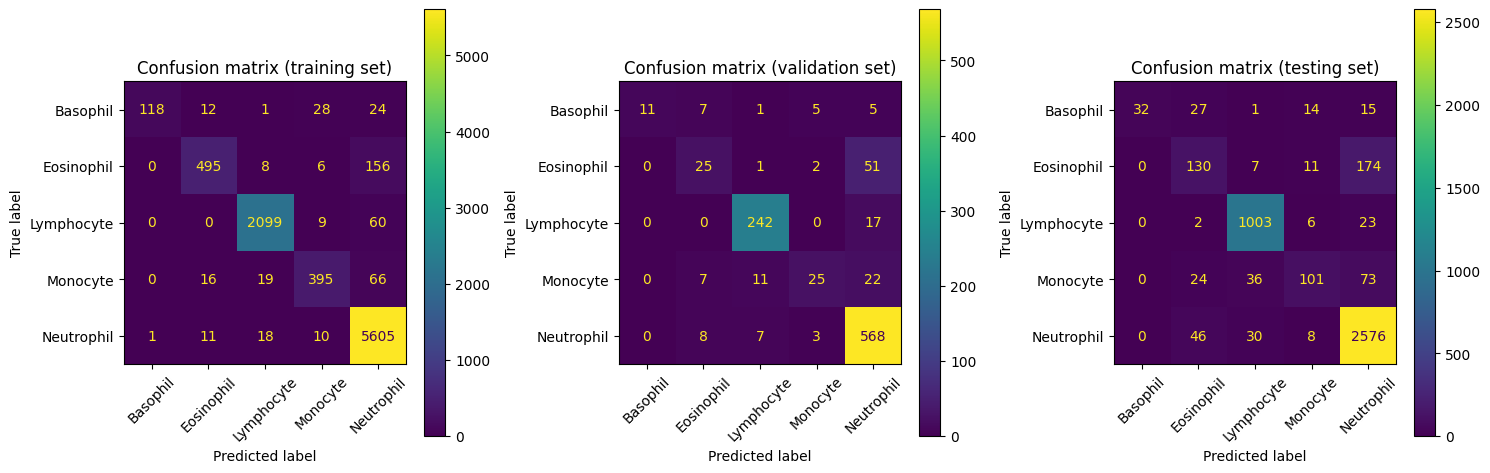

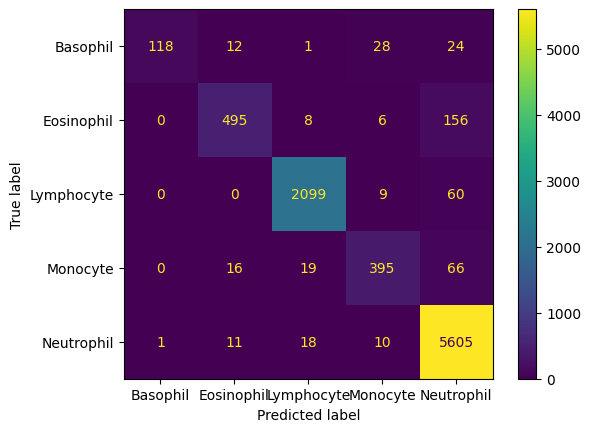

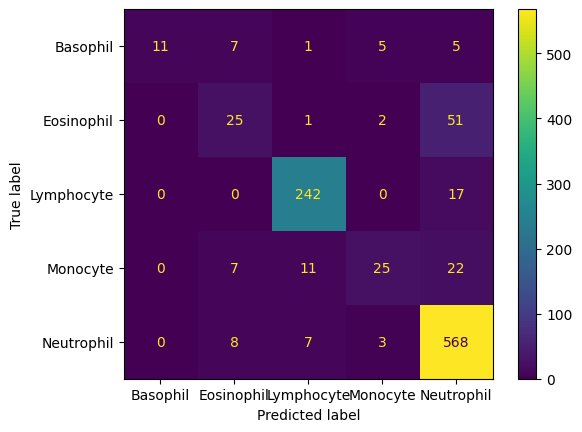

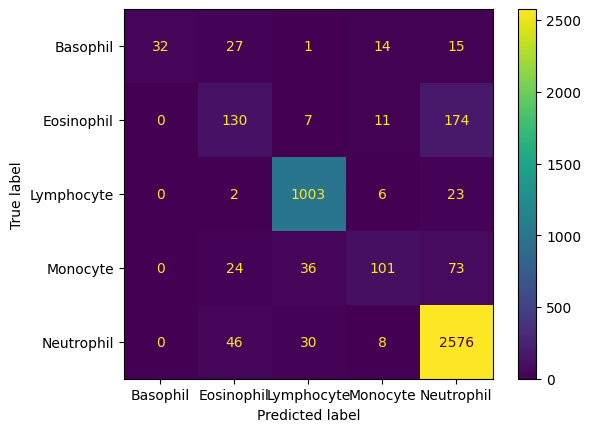

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# print('Confusion matrix (training set):')
cm = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=label_names  )
cm.plot(ax=ax[0])
ax[0].set_title('Confusion matrix (training set)')

# print('Confusion matrix (validation set):')
cm = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=label_names)
cm.plot(ax=ax[1])
ax[1].set_title('Confusion matrix (validation set)')

# print('Confusion matrix (testing set):')
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=label_names)
cm.plot(ax=ax[2])
ax[2].set_title('Confusion matrix (testing set)')

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

fig.tight_layout()
plt.show()

# Plain

In [32]:
label_names = sorted(train_metadata['label'].unique())
X_train, X_test = [], []
for label in tqdm(label_names):
    X_train.append(np.load('../datasets/wbc/clean/hog_features_plain_train_{}.npz'.format(label))['arr_0'])
    X_test.append(np.load('../datasets/wbc/clean/hog_features_plain_test_{}.npz'.format(label))['arr_0'])

X_train = np.concatenate(X_train)
X_test  = np.concatenate(X_test)

le = LabelEncoder()
le.fit(train_metadata['label'])
y_train = le.transform(train_metadata['label'])
y_test  = le.transform(test_metadata['label'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


In [33]:
n_jobs = multiprocessing.cpu_count() // 2
print('Num jobs:', n_jobs)

model = xgb.XGBClassifier(
    n_estimators=20,
    random_state=0,
    n_jobs=n_jobs,
    early_stopping_rounds=5
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

Num jobs: 4
[0]	validation_0-mlogloss:1.17651
[1]	validation_0-mlogloss:0.95211
[2]	validation_0-mlogloss:0.81032
[3]	validation_0-mlogloss:0.71461
[4]	validation_0-mlogloss:0.63904
[5]	validation_0-mlogloss:0.58672
[6]	validation_0-mlogloss:0.54488
[7]	validation_0-mlogloss:0.51109
[8]	validation_0-mlogloss:0.49112
[9]	validation_0-mlogloss:0.47308


## Metrics

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_val   = model.predict(X_val)
y_pred_test  = model.predict(X_test)

train_score  = f1_score(y_train, y_pred_train, average='micro')
val_score    = f1_score(y_val, y_pred_val, average='micro')
test_score   = f1_score(y_test, y_pred_test, average='micro')

print('Training metrics:')
print(classification_report(y_train, y_pred_train, digits=4))
print('Validation metrics:')
print(classification_report(y_val, y_pred_val, digits=4))
print('Testing metrics:')
print(classification_report(y_test, y_pred_test, digits=4))

## Conf Matrix

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# print('Confusion matrix (training set):')
cm = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=label_names  )
cm.plot(ax=ax[0])
ax[0].set_title('Confusion matrix (training set)')

# print('Confusion matrix (validation set):')
cm = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=label_names)
cm.plot(ax=ax[1])
ax[1].set_title('Confusion matrix (validation set)')

# print('Confusion matrix (testing set):')
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=label_names)
cm.plot(ax=ax[2])
ax[2].set_title('Confusion matrix (testing set)')

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

fig.tight_layout()
plt.show()